## Convolutional Neural Network for AWS Spot Price Prediction


**Author: Sumaia Parveen Shupti, Siti Khotijah, Ruichong Wang**

Updated on: 06/11/2021

#### Important Reference: **machinelearningmastery.com** 

* [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

### Import Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(0)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(0)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(0)

# Seed value (can actually be different for each attribution step)
seed_value= 0
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    
import os 
import random as rn
import keras
from tensorflow.compat.v1.keras import backend as K

#-----------------------------Keras reproducible------------------#
SEED = 0

tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
K.set_session(sess)
#-----------------------------------------------------------------#

### Load Dataset

In [2]:
# Importing Training Set
dataset_train = pd.read_csv('../input/flant-processed-data/train_test_train.csv')
train = dataset_train.copy()

import datetime as dt
dataset_train['Timestamp'] = pd.to_datetime(dataset_train['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f')
dataset_train['Date']= pd.to_datetime(dataset_train['Timestamp']).apply(lambda x: x.date())
dataset_train["Date"] = pd.to_datetime(dataset_train["Date"], format = '%Y-%m-%d')
dataset_train.head()

,AvailabilityZone,InstanceType,Timestamp,Timedel,SpotPrice,Date
0,0,0,2021-02-16 00:00:00+00:00,684.0,0.0671,2021-02-16
1,0,0,2021-02-16 01:00:00+00:00,720.0,0.0671,2021-02-16
2,0,0,2021-02-16 02:00:00+00:00,756.0,0.0671,2021-02-16
3,0,0,2021-02-16 03:00:00+00:00,792.0,0.0671,2021-02-16
4,0,0,2021-02-16 04:00:00+00:00,828.0,0.0671,2021-02-16


In [3]:
dataset_test = pd.read_csv('../input/flant-processed-data/train_test_test.csv')
dataset_test['Timestamp'] = pd.to_datetime(dataset_test['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f')
dataset_test['Date']= pd.to_datetime(dataset_test['Timestamp']).apply(lambda x: x.date())
dataset_test["Date"] = pd.to_datetime(dataset_test["Date"], format = '%Y-%m-%d')
dataset_test

,AvailabilityZone,InstanceType,Timestamp,Timedel,SpotPrice,Date
0,0,0,2021-04-10 00:00:00+00:00,46476.0,0.0671,2021-04-10
1,0,0,2021-04-10 01:00:00+00:00,46512.0,0.0671,2021-04-10
2,0,0,2021-04-10 02:00:00+00:00,46548.0,0.0671,2021-04-10
3,0,0,2021-04-10 03:00:00+00:00,46584.0,0.0671,2021-04-10
4,0,0,2021-04-10 04:00:00+00:00,46620.0,0.0671,2021-04-10
...,...,...,...,...,...,...
304910,5,388,2021-04-16 17:00:00+00:00,52272.0,0.1116,2021-04-16
304911,5,388,2021-04-16 18:00:00+00:00,52308.0,0.1116,2021-04-16
304912,5,388,2021-04-16 19:00:00+00:00,52344.0,0.1116,2021-04-16
304913,5,388,2021-04-16 20:00:00+00:00,52380.0,0.1116,2021-04-16


### Dropping the 'Timestamp' Column

In [4]:
def feat_(df):

    df.drop('Timestamp', axis = 1, inplace = True)
    df = df.reset_index(drop = True)

    print (df.shape)
    return df

### Train Set

In [5]:
dataset_train = feat_(dataset_train)
dataset_train

(2289706, 5)


,AvailabilityZone,InstanceType,Timedel,SpotPrice,Date
0,0,0,684.0,0.0671,2021-02-16
1,0,0,720.0,0.0671,2021-02-16
2,0,0,756.0,0.0671,2021-02-16
3,0,0,792.0,0.0671,2021-02-16
4,0,0,828.0,0.0671,2021-02-16
...,...,...,...,...,...
2289701,5,388,46296.0,0.1116,2021-04-09
2289702,5,388,46332.0,0.1116,2021-04-09
2289703,5,388,46368.0,0.1116,2021-04-09
2289704,5,388,46404.0,0.1116,2021-04-09


### Test Set

In [6]:
dataset_test = feat_(dataset_test)
dataset_test

(304915, 5)


,AvailabilityZone,InstanceType,Timedel,SpotPrice,Date
0,0,0,46476.0,0.0671,2021-04-10
1,0,0,46512.0,0.0671,2021-04-10
2,0,0,46548.0,0.0671,2021-04-10
3,0,0,46584.0,0.0671,2021-04-10
4,0,0,46620.0,0.0671,2021-04-10
...,...,...,...,...,...
304910,5,388,52272.0,0.1116,2021-04-16
304911,5,388,52308.0,0.1116,2021-04-16
304912,5,388,52344.0,0.1116,2021-04-16
304913,5,388,52380.0,0.1116,2021-04-16


We will concatenate the train and test set for convenience.

In [7]:
dataset_ = pd.concat([dataset_train, dataset_test])
dataset_

,AvailabilityZone,InstanceType,Timedel,SpotPrice,Date
0,0,0,684.0,0.0671,2021-02-16
1,0,0,720.0,0.0671,2021-02-16
2,0,0,756.0,0.0671,2021-02-16
3,0,0,792.0,0.0671,2021-02-16
4,0,0,828.0,0.0671,2021-02-16
...,...,...,...,...,...
304910,5,388,52272.0,0.1116,2021-04-16
304911,5,388,52308.0,0.1116,2021-04-16
304912,5,388,52344.0,0.1116,2021-04-16
304913,5,388,52380.0,0.1116,2021-04-16


### Transform the data into a time series problem

In [8]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### We will use the current hour and the last 2 hours to forecast 1 hour ahead

In [9]:
window = 2
lag = 1
series = series_to_supervised(dataset_.drop('Date', axis=1), window=window, lag=lag)
series

,AvailabilityZone(t-2),InstanceType(t-2),Timedel(t-2),SpotPrice(t-2),AvailabilityZone(t-1),InstanceType(t-1),Timedel(t-1),SpotPrice(t-1),AvailabilityZone(t),InstanceType(t),Timedel(t),SpotPrice(t),AvailabilityZone(t+1),InstanceType(t+1),Timedel(t+1),SpotPrice(t+1)
2,0.0,0.0,684.0,0.0671,0.0,0.0,720.0,0.0671,0,0,756.0,0.0671,0.0,0.0,792.0,0.0671
3,0.0,0.0,720.0,0.0671,0.0,0.0,756.0,0.0671,0,0,792.0,0.0671,0.0,0.0,828.0,0.0671
4,0.0,0.0,756.0,0.0671,0.0,0.0,792.0,0.0671,0,0,828.0,0.0671,0.0,0.0,864.0,0.0671
5,0.0,0.0,792.0,0.0671,0.0,0.0,828.0,0.0671,0,0,864.0,0.0671,0.0,0.0,900.0,0.0671
6,0.0,0.0,828.0,0.0671,0.0,0.0,864.0,0.0671,0,0,900.0,0.0671,0.0,0.0,936.0,0.0671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304909,5.0,388.0,52164.0,0.1116,5.0,388.0,52200.0,0.1116,5,388,52236.0,0.1116,5.0,388.0,52272.0,0.1116
304910,5.0,388.0,52200.0,0.1116,5.0,388.0,52236.0,0.1116,5,388,52272.0,0.1116,5.0,388.0,52308.0,0.1116
304911,5.0,388.0,52236.0,0.1116,5.0,388.0,52272.0,0.1116,5,388,52308.0,0.1116,5.0,388.0,52344.0,0.1116
304912,5.0,388.0,52272.0,0.1116,5.0,388.0,52308.0,0.1116,5,388,52344.0,0.1116,5.0,388.0,52380.0,0.1116


### Remove unwanted columns

In [10]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['AvailabilityZone', 'InstanceType', 'Timedel']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['AvailabilityZone', 'InstanceType', 'Timedel']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['AvailabilityZone(t)', 'InstanceType(t)', 'Timedel(t)'], axis=1, inplace=True)
series

,SpotPrice(t-2),SpotPrice(t-1),SpotPrice(t),SpotPrice(t+1)
2,0.0671,0.0671,0.0671,0.0671
3,0.0671,0.0671,0.0671,0.0671
4,0.0671,0.0671,0.0671,0.0671
5,0.0671,0.0671,0.0671,0.0671
6,0.0671,0.0671,0.0671,0.0671
...,...,...,...,...
304909,0.1116,0.1116,0.1116,0.1116
304910,0.1116,0.1116,0.1116,0.1116
304911,0.1116,0.1116,0.1116,0.1116
304912,0.1116,0.1116,0.1116,0.1116


### Train/validation split

In [11]:
lag_size = 1 

# Label
labels_col = 'SpotPrice(t+%d)' % lag_size
labels = series[[labels_col]]
series = series.drop(labels_col, axis=1)
series

,SpotPrice(t-2),SpotPrice(t-1),SpotPrice(t)
2,0.0671,0.0671,0.0671
3,0.0671,0.0671,0.0671
4,0.0671,0.0671,0.0671
5,0.0671,0.0671,0.0671
6,0.0671,0.0671,0.0671
...,...,...,...
304909,0.1116,0.1116,0.1116
304910,0.1116,0.1116,0.1116
304911,0.1116,0.1116,0.1116
304912,0.1116,0.1116,0.1116


In [12]:
labels

,SpotPrice(t+1)
2,0.0671
3,0.0671
4,0.0671
5,0.0671
6,0.0671
...,...
304909,0.1116
304910,0.1116
304911,0.1116
304912,0.1116


In [13]:
series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2594618 entries, 2 to 304913
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SpotPrice(t-2)  float64
 1   SpotPrice(t-1)  float64
 2   SpotPrice(t)    float64
dtypes: float64(3)
memory usage: 79.2 MB


In [14]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2594618 entries, 2 to 304913
Data columns (total 1 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SpotPrice(t+1)  float64
dtypes: float64(1)
memory usage: 39.6 MB


In [15]:
X_train = series[:len(dataset_train)- window]
X_train

,SpotPrice(t-2),SpotPrice(t-1),SpotPrice(t)
2,0.0671,0.0671,0.0671
3,0.0671,0.0671,0.0671
4,0.0671,0.0671,0.0671
5,0.0671,0.0671,0.0671
6,0.0671,0.0671,0.0671
...,...,...,...
2289701,0.1116,0.1116,0.1116
2289702,0.1116,0.1116,0.1116
2289703,0.1116,0.1116,0.1116
2289704,0.1116,0.1116,0.1116


In [16]:
Y_train = labels[:len(dataset_train)- window]
Y_train

,SpotPrice(t+1)
2,0.0671
3,0.0671
4,0.0671
5,0.0671
6,0.0671
...,...
2289701,0.1116
2289702,0.1116
2289703,0.1116
2289704,0.1116


In [17]:
X_valid = series[len(dataset_train)- window:]
X_valid

,SpotPrice(t-2),SpotPrice(t-1),SpotPrice(t)
0,0.1116,0.1116,0.0671
1,0.1116,0.0671,0.0671
2,0.0671,0.0671,0.0671
3,0.0671,0.0671,0.0671
4,0.0671,0.0671,0.0671
...,...,...,...
304909,0.1116,0.1116,0.1116
304910,0.1116,0.1116,0.1116
304911,0.1116,0.1116,0.1116
304912,0.1116,0.1116,0.1116


In [18]:
Y_valid = labels[len(dataset_train)- window:]
Y_valid

,SpotPrice(t+1)
0,0.0671
1,0.0671
2,0.0671
3,0.0671
4,0.0671
...,...
304909,0.1116
304910,0.1116
304911,0.1116
304912,0.1116


### Optimizing the memory usage

In [19]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

### Let's look at the memory usage given by df.info()

In [20]:
X_train = reduce_mem_usage(X_train)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289704 entries, 2 to 2289705
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SpotPrice(t-2)  float16
 1   SpotPrice(t-1)  float16
 2   SpotPrice(t)    float16
dtypes: float16(3)
memory usage: 30.6 MB


In [21]:
X_valid = reduce_mem_usage(X_valid)
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304914 entries, 0 to 304913
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SpotPrice(t-2)  304914 non-null  float16
 1   SpotPrice(t-1)  304914 non-null  float16
 2   SpotPrice(t)    304914 non-null  float16
dtypes: float16(3)
memory usage: 4.1 MB


In [22]:
Y_train = reduce_mem_usage(Y_train)
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289704 entries, 2 to 2289705
Data columns (total 1 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SpotPrice(t+1)  float16
dtypes: float16(1)
memory usage: 21.8 MB


In [23]:
Y_valid = reduce_mem_usage(Y_valid)
Y_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304914 entries, 0 to 304913
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SpotPrice(t+1)  304914 non-null  float16
dtypes: float16(1)
memory usage: 2.9 MB


### Turning into string => float => numpy array also helps..

In [24]:
def mem_opt(t_set):
    
    cols = t_set.columns.tolist()
    t_set = t_set[cols].astype(str)
    t_set = t_set.astype(float)
    t_set = t_set.to_numpy()
    print (t_set.shape)
    return t_set

In [25]:
X_train = mem_opt(X_train)

(2289704, 3)


In [26]:
X_valid = mem_opt(X_valid)

(304914, 3)


In [27]:
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

print('Train labels shape', Y_train.shape)
print('Validation labels shape', Y_valid.shape)

Train set shape (2289704, 3)
Validation set shape (304914, 3)
Train labels shape (2289704, 1)
Validation labels shape (304914, 1)


### CNN for Time Series Forecasting
For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.

The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, 1]**.

### Data preprocess

* Reshape from **[samples, timesteps]** into **[samples, timesteps, 1]**.

*Note*: **timestep = window + lag**

In our case, **window = 2**, **lag = 1**.

In [28]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (2289704, 3, 1)
Validation set shape (304914, 3, 1)


In [29]:
epochs = 50
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

In [30]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mae', optimizer=adam)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 64)             192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 6,793
Trainable params: 6,793
Non-trainable params: 0
_________________________________________________________________


In [31]:
%%time
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=1, callbacks=[es, mcp])

Epoch 1/50
71554/71554 [==============================] - 70s 968us/step - loss: 0.0064 - val_loss: 0.0067

Epoch 00001: val_loss improved from inf to 0.00674, saving model to weights.h5
Epoch 2/50
71554/71554 [==============================] - 69s 969us/step - loss: 0.0020 - val_loss: 0.0060

Epoch 00002: val_loss improved from 0.00674 to 0.00600, saving model to weights.h5
Epoch 3/50
71554/71554 [==============================] - 70s 978us/step - loss: 0.0019 - val_loss: 0.0065

Epoch 00003: val_loss did not improve from 0.00600
Epoch 4/50
71554/71554 [==============================] - 68s 956us/step - loss: 0.0018 - val_loss: 0.0059

Epoch 00004: val_loss improved from 0.00600 to 0.00593, saving model to weights.h5
Epoch 5/50
71554/71554 [==============================] - 68s 946us/step - loss: 0.0018 - val_loss: 0.0065

Epoch 00005: val_loss did not improve from 0.00593
Epoch 6/50
71554/71554 [==============================] - 66s 922us/step - loss: 0.0019 - val_loss: 0.0057

Epoch

In [32]:
%%time
cnn_valid_pred = model_cnn.predict(X_valid_series)

CPU times: user 4.6 s, sys: 849 ms, total: 5.45 s
Wall time: 4.02 s


### Visualize the Results

In [33]:
comparison = pd.read_csv('../input/flant-processed-data/train_test_test.csv')
comparison = comparison[:len(dataset_test)-lag]
comparison['Predicted_Price'] = cnn_valid_pred
comparison.columns =['AvailabilityZone', 'InstanceType', 'Timestamp', 'Timedel', 'Actual_Price','Predicted_Price']
comparison

,AvailabilityZone,InstanceType,Timestamp,Timedel,Actual_Price,Predicted_Price
0,0,0,2021-04-10 00:00:00+00:00,46476.0,0.0671,0.081938
1,0,0,2021-04-10 01:00:00+00:00,46512.0,0.0671,0.062277
2,0,0,2021-04-10 02:00:00+00:00,46548.0,0.0671,0.066749
3,0,0,2021-04-10 03:00:00+00:00,46584.0,0.0671,0.066749
4,0,0,2021-04-10 04:00:00+00:00,46620.0,0.0671,0.066749
...,...,...,...,...,...,...
304909,5,388,2021-04-16 16:00:00+00:00,52236.0,0.1116,0.111110
304910,5,388,2021-04-16 17:00:00+00:00,52272.0,0.1116,0.111110
304911,5,388,2021-04-16 18:00:00+00:00,52308.0,0.1116,0.111110
304912,5,388,2021-04-16 19:00:00+00:00,52344.0,0.1116,0.111110


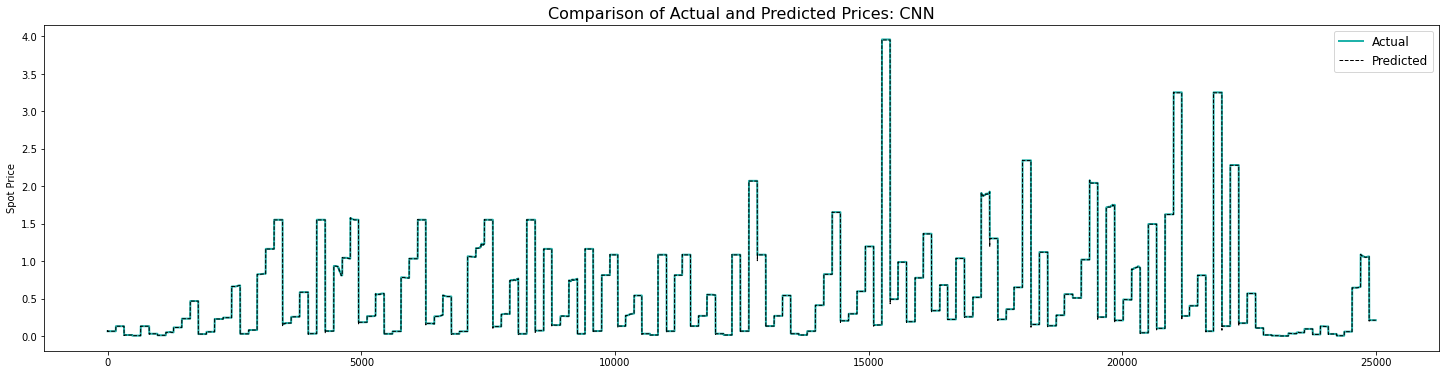

In [34]:
plt.rcParams["figure.figsize"] = [25, 6]

comparison.Actual_Price[:25000].plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison.Predicted_Price[:25000].plot(linewidth = 1, label = 'Predicted', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('Spot Price')
plt.title('Comparison of Actual and Predicted Prices: CNN', fontsize = 16)
plt.show()

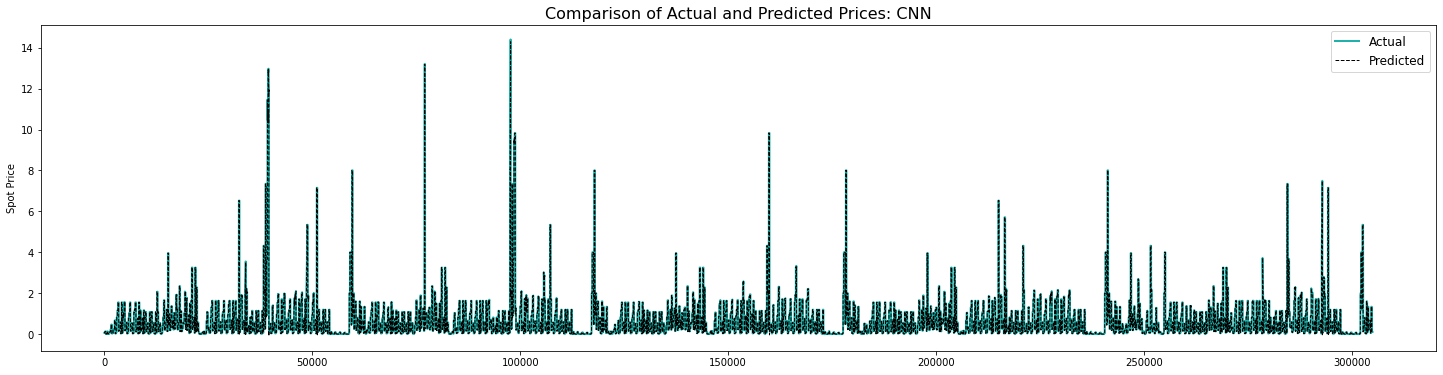

In [35]:
plt.rcParams["figure.figsize"] = [25, 6]

comparison.Actual_Price.plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison.Predicted_Price.plot(linewidth = 1, label = 'Predicted', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('Spot Price')
plt.title('Comparison of Actual and Predicted Prices: CNN', fontsize = 16)
plt.show()

### Evalutaion Metrics

In [36]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison['Actual_Price'] - comparison['Predicted_Price']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison['Actual_Price']).mean() * 100
r2 = r2_score(comparison['Actual_Price'], comparison['Predicted_Price'])

In [37]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 0.0016
Root Mean Square Error: 0.0038
Mean Absolute Percentage Error: 1.2246
R2 Score: 1.0000
